![](header.jpg)

# Augmented Reality Markers (ar_markers)

Kevin J. Walchko, Phd

11 July 2017

----------

We are not going to do augmented reality, but we are going to learn how the markers work and use it for robotics. This will also give you insite on how [QR codes](https://en.wikipedia.org/wiki/QR_code) work. For our applications, we want to be able to mark real world objects and have our robot know what they are (think road signs or mile markers on the highway).

## Objectives

- detect AR markers in an image
- understand how QR codes work
- understand how Hamming codes work

## References

- [Source artical for the overview of how the marker works](http://iplimage.com/blog/approach-encodedecode-black-white-marker/)
- [Hamming (7,4)](https://en.wikipedia.org/wiki/Hamming(7,4))

## Setup

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time

# make sure you have installed the library with:
#    pip install -U ar_markers
from ar_markers import detect_markers


## How Do Marker Work?

![](ar_marker_pics/1D_2D_3D.png)
![](ar_marker_pics/markers.png)

There are lots of different types of markers out there in the world. Some are free to use and some are protected by intellectual property rights. Markers that machines can read range from simple bar codes on food products that can be scaned to much more complex 2D and 3D markers. We are going to look at a simple but useful type of 2D marker shown below.

![](ar_marker_pics/flyer-hamming.png)

The approach implemented here uses a type of Hamming code with the possibility to correct errors. This error correction is particularly useful when the marker is small or blurred in the image. Also, the idea is to be able to decipher the code provided by the marker without having to rotate it because there is a known pattern. Once that’s done, it becomes easy to use the black and white squares to read the signature and, if necessary, correct the code if an error is found.

## Hamming Code [7,4]

![](https://upload.wikimedia.org/wikipedia/en/0/08/Richard_Hamming.jpg)

First let's take a little side step and understand how a 7 bit hamming code works. In coding theory, Hamming(7,4) is a linear error-correcting code that encodes four bits of data into seven bits by adding three parity bits. It is a member of a larger family of Hamming codes, but the term Hamming code often refers to this specific code that [Richard W. Hamming](https://en.wikipedia.org/wiki/Richard_Hamming) introduced in 1950. At the time, Hamming worked at Bell Telephone Laboratories and was frustrated with the error-prone punched card reader, which is why he started working on error-correcting codes.

The marker shown above is a 5x5 grid marker with a Hamming code [7,4] to detect and help correct errors. This form of hamming code uses 7 bits with 4 bits of data and 3 bits of parity. This code is capable of correcting 1 error or bit flip.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Hamming%287%2C4%29.svg/350px-Hamming%287%2C4%29.svg.png)

A nice graphical interpretation is shown above. The idea is the data bits $d_1, d_2, d_3, d_4$ are covered by multiple parity bits giving redundancy. For example $d_1$ is covered by $p_1$ and $p_2$ while $d_2$ is covered by $p_1$ and $p_3$. This redundancy allows the code to correct for 1 error. Error can come from many sources:

- the marker is damaged
- a read error occurred due to:
    - lighting
    - camera noise
    - atmosphere interference
    - data bit falls between 2 pixels and is read incorrectly
    - etc

Given a 4 bit message (m) we can encode it using a code *generator matrix* ($G_{4 \times 7}$). We can also check the parity of an encoded message (e) using a *parity check matrix* ($H_{3 \times 7}$). To decode an encoded message we will use a *regeneration matrix* (R). Where:

$$
G = \begin{bmatrix}
    1 & 1 & 0 & 1 \\
    1 & 0 & 1 & 1 \\
    1 & 0 & 0 & 0 \\
    0 & 1 & 1 & 1 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
\end{bmatrix} \\
H = \begin{bmatrix}
    1 & 1 & 1 & 0 & 1 & 0 & 0 \\
    1 & 0 & 1 & 1 & 0 & 1 & 0 \\
    1 & 1 & 0 & 1 & 0 & 0 & 1 
\end{bmatrix} \\
R = \begin{bmatrix}
    1 & 0 & 1 & 0 & 1 & 0 & 1 \\
    0 & 1 & 1 & 0 & 0 & 1 & 1 \\
    0 & 0 & 0 & 1 & 1 & 1 & 1
\end{bmatrix} \\
e = G \times m = \begin{bmatrix} d_1 & d_2 & d_3 & d_4 & p_1 & p_2 & p_3 \end{bmatrix} \\
\text{parity check} = H \times e \\
m = R \times e
$$

A good message has the parity check result in $\begin{bmatrix} 0 & 0 & 0 \end{bmatrix}$. If an error is present, the parity bits form a binary number which tells you which of the 7 bits is flipped. Again, this can only handle 1 error and correct.

## Step 1: Find the Pattern

Once the marker’s borders are found in the image, we are looking at four specific squares place at the corners of our 5×5 pattern (see the picture). These registration marks tell us where the data and parity bits are in the 5x5 array.

![](ar_marker_pics/flyer-hamming-s1.png)

## Step 2: Read the Signature

Once the orientation is decided we can construct the signature. In the 5×5 case it’s straightforward to read 3 signatures that contains 7 bits. Then for each signature:

- compute the binary parity vector (composed of 3 bits) and check if any error,
- if any error, correct it using the binary parity vector corresponding value,
- then extract the 4 bits of data and group them using the 3 signatures.

![](ar_marker_pics/flyer-hamming-s2.png)

## Step 3: Calculate the Code

Finally, using the bits of data contained in the 3 signatures, compute the code that corresponds to this binary vector.

![](ar_marker_pics/flyer-hamming-s3.png)

Once errors are checked and corrected, the 3 signatures (green, red and blue areas) are used to generate the binary code to decipher (12 bits aligned at the bottom). So our marker has 5 x 5 bits (black or white squares) which give us:

- 4 are used to understand orientation, the outter corners
- 9 are used to control errors and correct (if possible)
- 12 are used for our id

Thus we have a marker than can have a $2^{12}$ bit number with a value between 0 - 4095.


# Let's Try It Out

Here is what we are going to do:

1. setup our environment
1. play with Hamming Codes to understand better
1. read in the image
1. run it through the `ar_markers` detection function

------

In [3]:
def fix_binary(msg):
    # now, use the modulas operator to ensure it is a binary number
    ans = []
    for val in msg:
        ans.append(val%2)
    return np.array(ans)

# encode a message
G = np.array([
    [1,1,0,1],
    [1,0,1,1],
    [1,0,0,0],
    [0,1,1,1],
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1]
])

# decode and encoded message
R = np.array([
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1],
])

# check parity
H = np.array([
    [1, 0, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 0, 1, 1],
    [0, 0, 0, 1, 1, 1, 1],
])

# a 4 bit message we want to send
msg = np.array([1,0,1,1])

In [4]:
e = fix_binary(G.dot(msg))
print('encoded msg:', e)

parity_check = fix_binary(H.dot(e))
print('parity check:', parity_check)

decoded_msg = R.dot(e)
print('decoded message:', decoded_msg)

print('Does msg == decoded msg?', msg == decoded_msg)

encoded msg: [0 1 1 0 0 1 1]
parity check: [0 0 0]
decoded message: [1 0 1 1]
Does msg == decoded msg? [ True  True  True  True]


### 1 Error

We are going to corrupt each bit one at a time and detect it ... we are not fixing it. Notice if you read the parity code from right to left [$bit_0$, $bit_1$, $bit_2$], you can determine which bit needs to get flipped so the message is correct again.

In [5]:
for i in range(7):
    e = fix_binary(G.dot(msg))
    print('Corrupt bit', i+1, '--------------------------------------')
    e[i] = 0 if e[i] == 1 else 1

    parity_check = fix_binary(H.dot(e))
    print('  parity check:', parity_check)

    decoded_msg = R.dot(e)

Corrupt bit 1 --------------------------------------
  parity check: [1 0 0]
Corrupt bit 2 --------------------------------------
  parity check: [0 1 0]
Corrupt bit 3 --------------------------------------
  parity check: [1 1 0]
Corrupt bit 4 --------------------------------------
  parity check: [0 0 1]
Corrupt bit 5 --------------------------------------
  parity check: [1 0 1]
Corrupt bit 6 --------------------------------------
  parity check: [0 1 1]
Corrupt bit 7 --------------------------------------
  parity check: [1 1 1]


### 2 Errors

We are going to corrupt each bit one at a time and detect it ... we are not fixing it. Notice now, we can't identify the incorrect bit, but we know something bad is happening. Notice corrupted bit 1 and 6 give the same parity check: [1, 1, 0]. If you need protection from more than 1 error, then you need to select a different algorithm.

In [6]:
for i in range(7):
    e = fix_binary(G.dot(msg))
    e[i] = 0 if e[i] == 1 else 1
    j = (i+1)%7
    e[j] = 0 if e[j] == 1 else 1
    print('Corrupt bit', i+1, 'and', j+1, '--------------------------------------')

    parity_check = fix_binary(H.dot(e))
    print('  parity check:', parity_check)

    decoded_msg = R.dot(e)

Corrupt bit 1 and 2 --------------------------------------
  parity check: [1 1 0]
Corrupt bit 2 and 3 --------------------------------------
  parity check: [1 0 0]
Corrupt bit 3 and 4 --------------------------------------
  parity check: [1 1 1]
Corrupt bit 4 and 5 --------------------------------------
  parity check: [1 0 0]
Corrupt bit 5 and 6 --------------------------------------
  parity check: [1 1 0]
Corrupt bit 6 and 7 --------------------------------------
  parity check: [1 0 0]
Corrupt bit 7 and 1 --------------------------------------
  parity check: [0 1 1]


### Let's Try Markers Now

image dimensions [width, height, color depth]: (210, 210, 3)


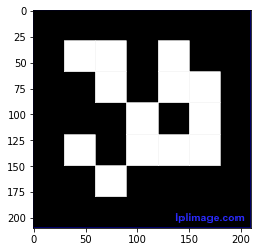

In [7]:
img = cv2.imread('ar_marker_pics/flyer-hamming.png')
plt.imshow(img);
print('image dimensions [width, height, color depth]:', img.shape)

In [17]:
markers = detect_markers(img)
# let's print the id of the marker
print(markers[0].id)

3388
